In [1]:
import sys
import numpy as np
sys.path.append("../")
import matplotlib.pyplot as plt
import torch
from irradiance.models.kan_success import KANDEMSpectrum
%cd ..

/home/christophschirninger/2024-HL-SPI3S-MEGS-AI


In [2]:
aia_stack = np.load('/mnt/disks/data-extended/preprocessed/AIA_256/AIA_2014-05-05T18:00:03.npy')
# checkpoint_path = '/home/christophschirninger/dem_runs/debug_dem.ckpt-v2.ckpt'
checkpoint_path = '/home/andres_munoz_j/dem_runs/scl_tst_shuf.ckpt.ckpt'
eve_norm_path = '/mnt/disks/data-extended/preprocessed/EVE/EVS_MEGS-A_stats.npy'
uv_norm = '/mnt/disks/data-extended/preprocessed/AIA_256_EVS_MEGS-AB_stats.npz'

eve_norm = np.load(eve_norm_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
model_ckpt = torch.load(checkpoint_path)

In [4]:
#model = KANDEMSpectrum.load_from_checkpoint(checkpoint_path)

In [5]:
aia_stack.shape

(9, 256, 256)

In [7]:
with torch.no_grad():

    x = torch.tensor(aia_stack)[None, 0:7, :, :].to(device)
    x = x.unfold(2, 3, 1).unfold(3, 3, 1) # batch, channel, pixel_x, pixel_y, kanfov, kanfov
    x = x.reshape(x.shape[0], x.shape[1], -1, 3, 3) # batch, channel, pixel_x*pixel_y, kanfov, kanfov
    x = x.transpose(1, 2) # batch, pixel_x*pixel_y, channel, kanfov, kanfov
    x = x.reshape(x.shape[0], x.shape[1], -1) # batch, pixelx_*pixel_y, channel*kanfov*kanfov
    x = x[:, :, None, :].expand((x.shape[0], x.shape[1], model_ckpt['model'].t_query_points.shape[0], x.shape[2])) # batch, pixel_x*pixel_y, t_query_points, channel*kanfov*kanfov
    # Normalize input
    x = x/model_ckpt['model'].uv_norm

    # Concatenate log10(T) subtracting base exponent
    x = torch.cat((x, (model_ckpt['model'].t_query_points - torch.tensor(model_ckpt['model'].base_temp_exponent).to(device))[None, None, :, None].expand(x.shape[0], x.shape[1], x.shape[2], 1)), dim=3)

    dem = model_ckpt['model'].forward(x.cpu()).squeeze()

In [10]:
dem.shape

torch.Size([64516, 20])

In [12]:
em = torch.trapezoid(dem, x=torch.pow(10, model_ckpt['model'].t_query_points.to('cpu')), dim=1) # batch, channel

In [19]:
np.sqrt(em.shape[0])

254.0

In [20]:
em = em.reshape((int(np.sqrt(em.shape[0])), int(np.sqrt(em.shape[0]))))

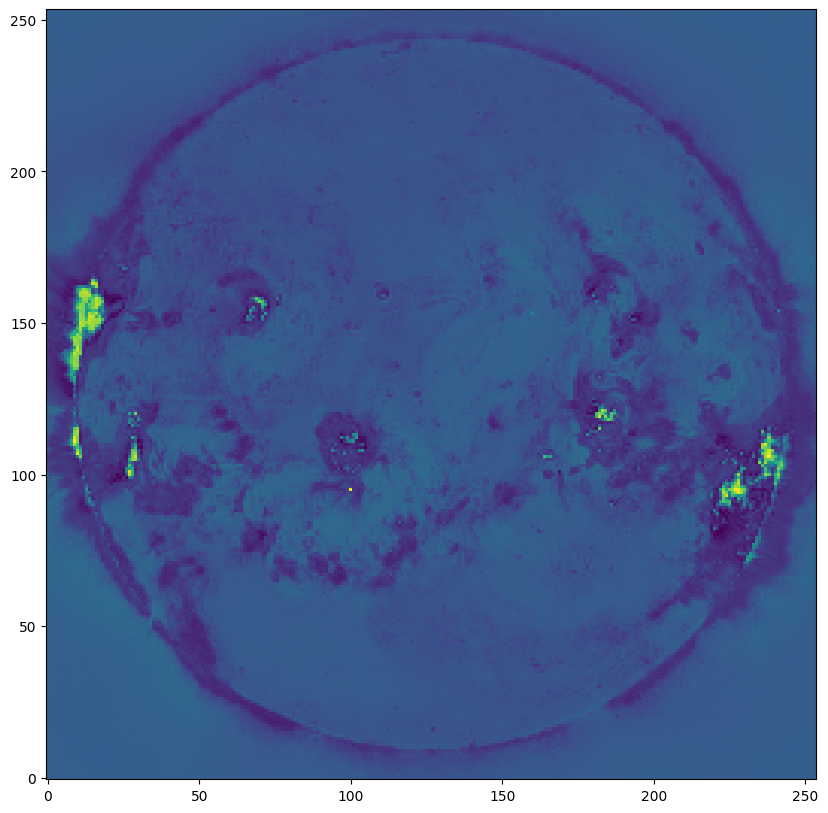

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(em.cpu().numpy(), origin='lower')
plt.show()